In [19]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
X, y = load_wine(return_X_y=True)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=0
)

In [4]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [5]:
np.set_printoptions(precision=4)
mean_vecs = []
for label in range(3):
    mean_vecs.append(np.mean(X_train_std[y_train == label], axis=0))
    print(f"MV {label}: {mean_vecs[label]}")

MV 0: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]
MV 1: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]
MV 2: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]


In [6]:
X_test_std.shape

(54, 13)

In [12]:
d = X_test_std.shape[1]  # Number of features
S_W = np.zeros((d, d))
for label, mv in zip(range(3), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter
print(f"Scaled within-class scatter matrix: {S_W.shape[0]}x{S_W.shape[1]}")

Scaled within-class scatter matrix: 13x13


In [14]:
mean_overall = np.mean(X_train_std, axis=0)
d = X_train_std.shape[1]  # Number of features
S_B = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train[y_train == i, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)  # Make column vector
    mean_overall = mean_overall.reshape(d, 1)
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)
print(f"Between-class scatter matrix: {S_B.shape[0]}x{S_B.shape[1]}")

Between-class scatter matrix: 13x13


In [15]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

In [16]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:i]) for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)
print("Eigenvalues in descending order:")
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in descending order:
349.61780890599397
172.7615221897938
3.3428382148413644e-14
2.842170943040401e-14
2.5545786180111397e-14
1.753393918073425e-14
1.753393918073425e-14
1.6579193995960887e-14
1.6579193995960887e-14
8.242524002707208e-15
8.242524002707208e-15
6.36835506006027e-15
2.97463437554573e-15


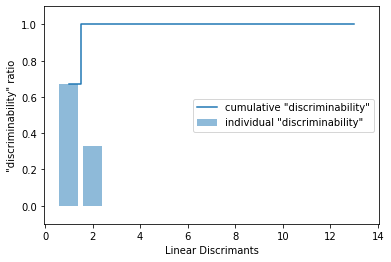

In [20]:
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)
plt.bar(
    range(1, 14),
    discr,
    alpha=0.5,
    align="center",
    label='individual "discriminability"',
)
plt.step(range(1, 14), cum_discr, where="mid", label='cumulative "discriminability"')
plt.ylabel('"discriminability" ratio')
plt.xlabel("Linear Discrimants")
plt.ylim([-0.1, 1.1])
plt.legend(loc="best")
plt.show()